In [1]:
import sys
sys.path.append('..')
import copy

from star_spin_up import *

import struct

import pickle
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [251]:
from matplotlib import font_manager

font_path =  '/home/jsn/landing/fonts/IBMPlexMono-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

import matplotlib as mpl
from cycler import cycler

colo =["#4878D0", "#EE854A", "#6ACC64", "#D65F5F", "#956CB4","#8C613C", "#DC7EC0", "#797979", "#D5BB67", "#82C6E2"]

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#4878D0", "#EE854A", "#6ACC64", "#D65F5F", "#956CB4","#8C613C", "#DC7EC0", "#797979", "#D5BB67", "#82C6E2"]) 

mpl.rcParams['image.origin'] = 'lower'

NameError: name 'masses' is not defined

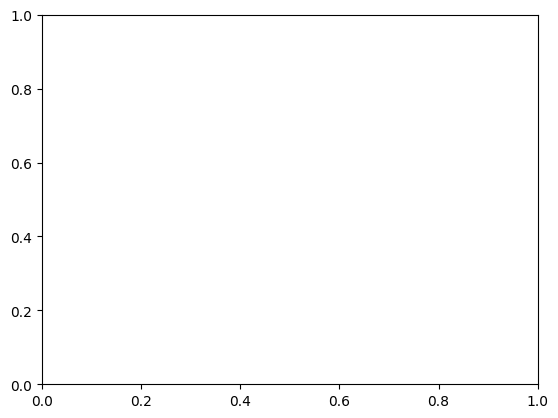

In [185]:
fig, ax = plt.subplots()

ax.plot(masses, pdf)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

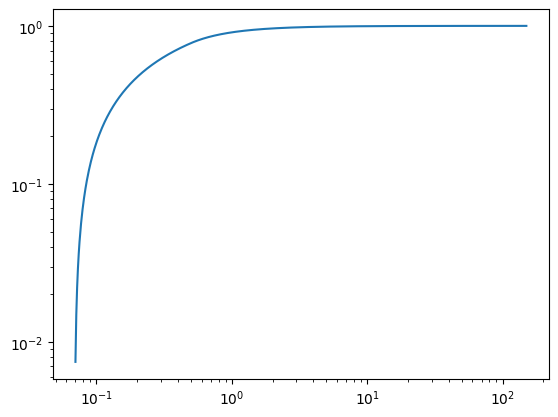

In [4]:
fig, ax = plt.subplots()

ax.plot(masses, cdf)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

In [5]:
def find_nearest(arr, val):
    arr = np.asarray(arr)
    i = (np.abs(arr - val)).argmin()
    return i, arr[i]

NameError: name 'random_val' is not defined

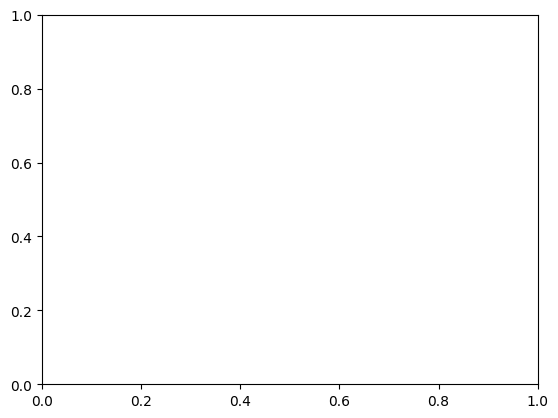

In [7]:
fig, ax = plt.subplots()

ax.axhline(random_val)
ax.plot(masses, cdf)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

In [8]:
class Star:
    def __init__(self, m, p):
        self.mass = m
        self.period = p
        
    def __init__(self):
        self.mass = None
        self.period = None

In [9]:
n_stars = 1e4
stars = []
for i in range(int(n_stars)):
    stars.append(Star())

In [10]:
mass_bins = [0.3, 0.4, 0.5, 0.8, 1.0]
mass_bin_width = 0.75

n_masses = 1e4

bin_counter = {}
for mb in mass_bins:
    bin_counter[mb] = 0

n_random_masses = 0
while n_random_masses < n_masses:
    
    random_val = np.random.uniform()
    nearest_index, _ = find_nearest(cdf, random_val)
    imf_rand_mass = masses[nearest_index]
    
    for mb in mass_bins:
        if mb-mass_bin_width/2 < imf_rand_mass < mb+mass_bin_width/2:
            bin_counter[mb] += 1
            stars[n_random_masses].mass = mb
            
            n_random_masses += 1
            break
            
mean_period = 8
lower_lim = 0.5
upper_lim = 18.5
std_period = 6

xs = np.linspace(lower_lim, upper_lim, 1000)
period_pdf = truncnorm.pdf(xs, lower_lim-mean_period, upper_lim+mean_period, loc=mean_period, scale=std_period)



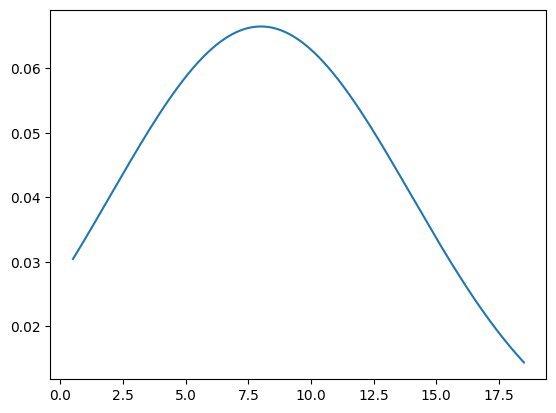

In [11]:
fig, ax = plt.subplots()

ax.plot(xs, period_pdf)

plt.show()

In [12]:
a, b = (lower_lim - mean_period) / std_period, (upper_lim - mean_period) / std_period
rvs = truncnorm.rvs(a, b, loc=mean_period, scale=std_period, size=1000000)


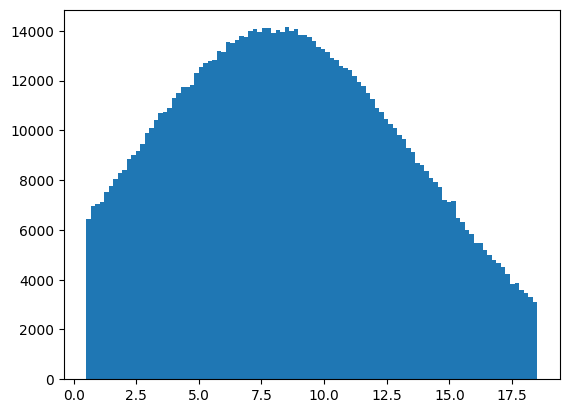

In [13]:
fig, ax = plt.subplots()

ax.hist(rvs, bins=100)

plt.show()

In [157]:
def read_stars_dat(filename):
    with open(filename,'rb') as f:

        n_iter = struct.unpack('>I', f.read(4))[0]
        dt = struct.unpack('>d', f.read(8))[0]
        n_stars = struct.unpack('>I', f.read(4))[0]
        
        star_times_series = []
        for _ in range(n_stars):            
            frame = []
            for _ in range(n_iter+1):
                s = {}
                s['age'] = (struct.unpack('>d', f.read(8))[0])
                s['mass'] = (struct.unpack('>d', f.read(8))[0])
                s['radius'] = (struct.unpack('>d', f.read(8))[0])
                s['inertia'] = (struct.unpack('>d', f.read(8))[0])
                s['period'] = (struct.unpack('>d', f.read(8))[0])
                s['rot_vel'] = (struct.unpack('>d', f.read(8))[0])
                s['ang_mom'] = (struct.unpack('>d', f.read(8))[0])
                frame.append(s)
            star_times_series.append(frame)

    return n_iter, dt, n_stars, star_times_series

In [172]:
filename = '../stars.dat'
n_iter, dt, n_stars, star_times_series = read_stars_dat(filename)
times = np.linspace(0, dt*n_iter, n_iter+1)

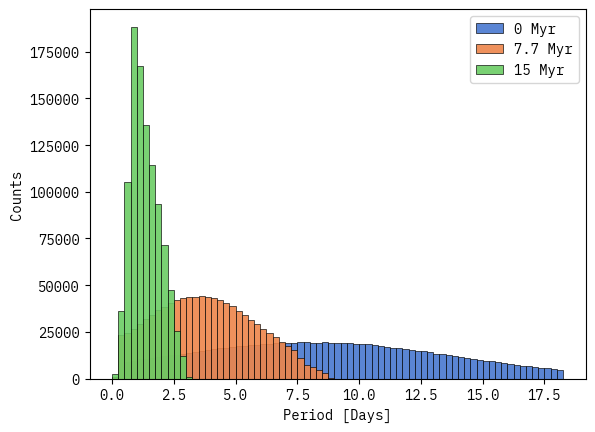

In [252]:
initial_periods = [star[0]['period']*365 for star in star_times_series]
mid_periods = [star[10]['period']*365 for star in star_times_series]
final_periods = [star[len(star)//2]['period']*365 for star in star_times_series]
bins = np.arange(0,18.5,0.25)

fig, ax = plt.subplots()

ax.hist(initial_periods, bins=bins, edgecolor='black', linewidth=0.5, label='0 Myr', alpha=0.9)
ax.hist(mid_periods, bins=bins, edgecolor='black', linewidth=0.5, label='7.7 Myr', alpha=0.9)
ax.hist(final_periods, bins=bins, edgecolor='black', linewidth=0.5, label = '15 Myr', alpha=0.9)

ax.set_xlabel('Period [Days]')
ax.set_ylabel('Counts')

ax.legend()
plt.show()

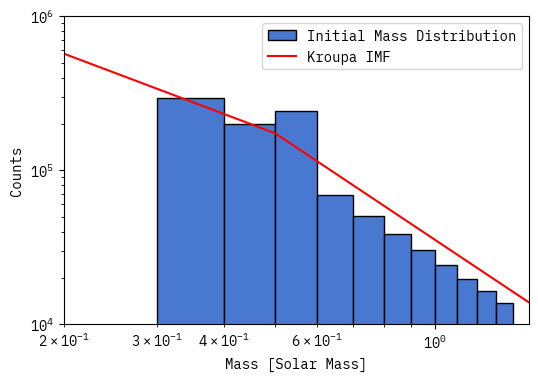

In [259]:
# CALCULATE IMF
v_imf = np.vectorize(imf_kroupa2013_unnorm, otypes=[float])

with open('../kroupa2013_norm.pickle', 'rb') as f:
    norm = pickle.load(f)

width = 1e-3
masses = np.arange(0.07, 150, width)
pdf = v_imf(masses)/norm # don't forget to normalize!

mass_distribution = [star[0]['mass'] for star in star_times_series]
bins = np.arange(0.3,1.4+0.1,0.1)

fig, ax = plt.subplots(figsize=(6,4))

ax.hist(mass_distribution, bins=bins, edgecolor='black', linewidth=1, label='Initial Mass Distribution')
ax.plot(masses, 3e5*pdf, color='red', label='Kroupa IMF')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.2, 1.5)
ax.set_ylim(1e4, 1e6)

ax.set_xlabel('Mass [Solar Mass]')
ax.set_ylabel('Counts')

ax.legend()

plt.show()

In [254]:
star_times_series[index][0].keys()

dict_keys(['age', 'mass', 'radius', 'inertia', 'period', 'rot_vel', 'ang_mom'])

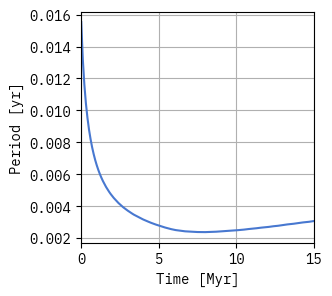

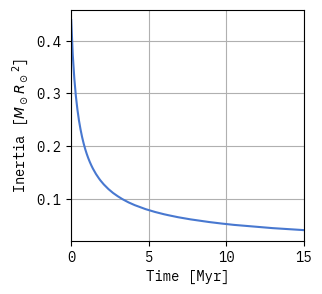

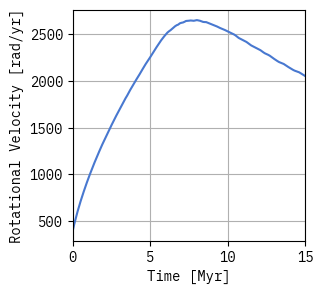

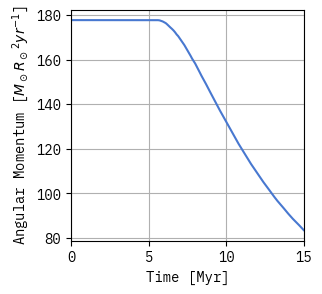

In [273]:
index = 1

fig, ax = plt.subplots(figsize=(3,3))
val = [el['period'] for el in star_times_series[index]]
ax.plot(times/1e6,val)
ax.set_xlim(0, 15)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Period [yr]')
ax.grid()

plt.show()

fig, ax = plt.subplots(figsize=(3,3))
val = [el['inertia'] for el in star_times_series[index]]
ax.plot(times/1e6,val)
ax.set_xlim(0, 15)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Inertia [$M_\odot {R_\odot}^2$]')
ax.grid()

plt.show()

fig, ax = plt.subplots(figsize=(3,3))
val = [el['rot_vel'] for el in star_times_series[index]]
ax.plot(times/1e6,val)
ax.set_xlim(0, 15)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Rotational Velocity [rad/yr]')
ax.grid()

plt.show()

fig, ax = plt.subplots(figsize=(3,3))
val = [el['ang_mom'] for el in star_times_series[index]]
ax.plot(times/1e6,val)
ax.set_xlim(0, 15)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Angular Momentum [$M_\odot {R_\odot}^2 yr^{-1}$]')
ax.grid()

plt.show()